In [2]:
!pip install "basemap == 1.3.0b1" "basemap-data == 1.3.0b1"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 881 kB 6.8 MB/s 
     |████████████████████████████████| 30.5 MB 305 kB/s 
     |████████████████████████████████| 219 kB 34.5 MB/s 
     |████████████████████████████████| 6.3 MB 44.0 MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37324 sha256=cf958eb7839fcd41968d4d313a1b945c9bb5aa594b8cadb7ae402c7bab955fde
  Stored in directory: /root/.cache/pip/wheels/43/f8/87/53c8cd41545ba20e536ea29a8fcb5431b5f477ca50d5dffbbe
Successfully built pyshp


In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.basemap import Basemap

In [5]:
#create nodes
G = nx.DiGraph()
nodes = open("Nodes.txt", 'r').read().split('\n')
lat = open("Latitude.txt", 'r').read().split('\n')
lon = open("Longitude.txt", 'r').read().split('\n')
airports = np.column_stack((nodes, lat, lon))

airports = airports[0:len(airports)-1,:]
clean_airports = []

for i in airports:
  if float(i[2]) <= 180 and float(i[2]) >= -180 and float(i[1]) <= 90 and float(i[1]) >= -90:
    clean_airports.append(i)
    G.add_node(i[0], pos = (i[1], i[2]))
clean_airports = np.asarray(clean_airports)

In [6]:
len(list(G.nodes))

5998

Text(0.5, 1.0, 'World map with airports')

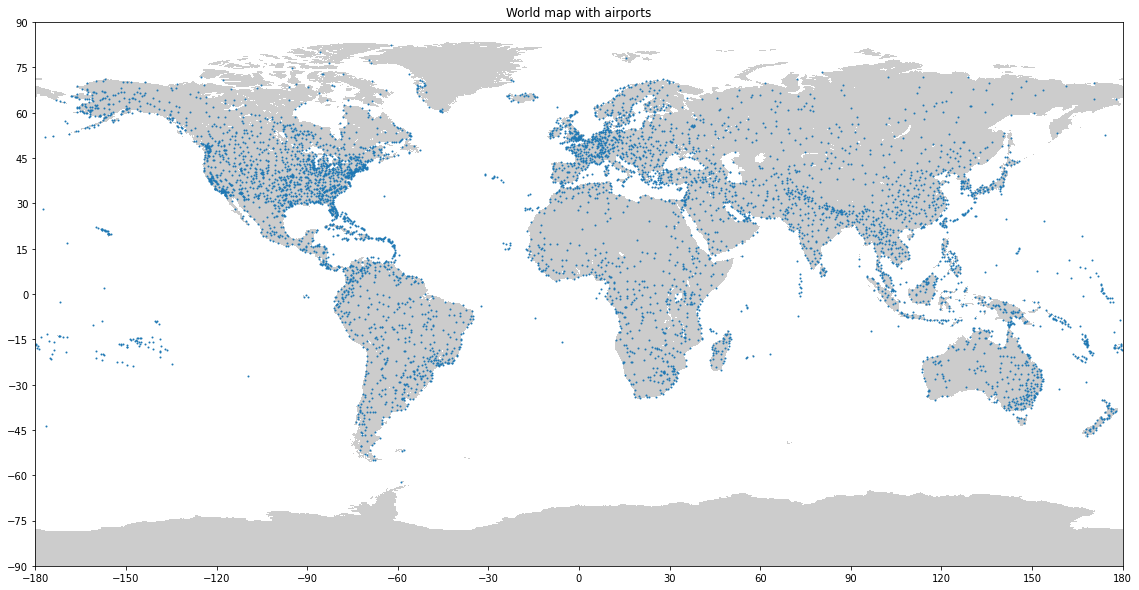

In [10]:
fig = plt.figure()
fig.set_size_inches(20, 10)
pos=nx.get_node_attributes(G,'pos')
for k, v in pos.items():
  pos[k] = (float(v[1]), float(v[0]))
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
m.drawlsmask()
nx.draw_networkx_nodes(G, pos, node_size = 1, label = False)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.xticks(range(-180,181, 30))
plt.yticks(range(-90,91, 15))
plt.title('World map with airports')

In [11]:
sou = open("Source.txt", 'r').read().split('\n')
des = open("Destination.txt", 'r').read().split('\n')
routes = np.column_stack((sou, des))
print(len(routes))

67663


In [13]:
delete_list_sou = list(set(routes[:,0]) - set(clean_airports[:,0]))
delete_list_des = list(set(routes[:,1]) - set(clean_airports[:,0]))
delete_list = []
for i in range(len(routes)):
  if routes[i][0] in delete_list_sou or routes[i][1] in delete_list_des:
    delete_list.append(i)
print(len(delete_list))

3933


In [14]:
routes = np.delete(routes, delete_list, 0)
print(len(routes))

63730


In [15]:
for i in routes:
  G.add_edge(i[0], i[1])

([<matplotlib.axis.YTick at 0x7f92448b2050>,
 <a list of 13 Text major ticklabel objects>)

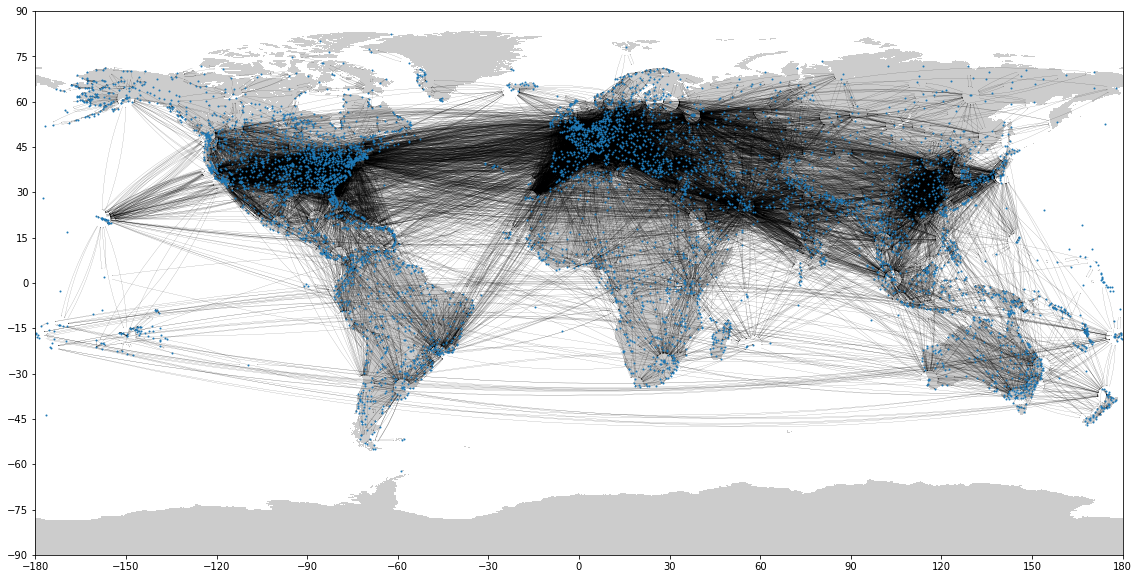

In [16]:
fig = plt.figure()
fig.set_size_inches(20, 10)
pos=nx.get_node_attributes(G,'pos')

for k, v in pos.items():
    pos[k] = (float(v[1]), float(v[0]))

m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
m.drawlsmask()    

nx.draw_networkx_nodes(G, pos, node_size = 1, label = False)
nx.draw_networkx_edges(G, pos,width = 0.1, arrowsize = 1 ,connectionstyle="arc3,rad=0.1")
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.xticks(range(-180,181, 30))
plt.yticks(range(-90,91, 15))
plt.title('World map with airport routes')

In [17]:
# create edge attribute weight with default None 
nx.set_edge_attributes(G, values=None, name = 'weight')

#count the occurance of the airport in the routes database
sources, sources_counts=np.unique(routes[:,0], return_counts=True)
des, des_counts=np.unique(routes[:,1], return_counts=True)

# create edge attribute source_occurrence with default None
nx.set_node_attributes(G, values=0, name = 'so')
for node in list(sources):
    G.nodes[node]['so'] = list(sources_counts)[list(sources).index(node)]

# create edge attribute destination_occurrence with default None
nx.set_node_attributes(G, values=0, name = 'do')
for node in list(des):
    G.nodes[node]['do'] = list(des_counts)[list(des).index(node)]

In [18]:
def add_weight_to_edges(graph):
    for node in graph.nodes:
        neighbors = [n for n in G.neighbors(node)]
        for nb in neighbors:
            graph[node][nb]['weight'] = np.mean([graph.nodes[node]['so'],G.nodes[node]['do'],graph.nodes[nb]['so'],graph.nodes[nb]['do']])

add_weight_to_edges(G)

In [121]:
# SIR model
def SIR(G, time, beta, gamma, rnd = True): #takes 0.2 seconds per time

  import math
  import random

  # Set edge attribute weight fraction (weight of an edge/average number of degrees in the neighborhood of the source node)
  nx.set_edge_attributes(G, values=None, name = 'weight fraction')
  nx.set_edge_attributes(G, values=None, name = 'weight total')

  weight_total = []
  for i in G.nodes():
    weight_neighbors = []
    for j in G.neighbors(i):
      weight_neighbors.append(G[i][j]['weight'])
    G.nodes[i]['weight total'] = sum(weight_neighbors)

  for i in G.nodes():
    for j in G.edges(i):
      if G.nodes[i]['weight total'] != 0:
        G.edges[j]['weight fraction'] = G.edges[j]['weight']/G.nodes[i]['weight total']

  # create node attribute degree
  nx.set_node_attributes(G, values = 0, name = 'degree')
  for i in G.nodes():
    G.nodes[i]['degree'] = G.degree[i]

  # remove airports with 0 degree
  delete_list = []
  for i in G.nodes():
    if G.nodes[i]['degree'] == 0:
      delete_list.append(i)
  for i in delete_list:
    G.remove_node(i)

  # Add node attribute 'inf_time', as in time since infection
  nx.set_node_attributes(G, values = 1, name  = 'inf_time')

  ni = (1-gamma/beta)*((math.exp(beta - gamma)**1)/(1+math.exp(beta - gamma)**1)) # infected portion intitally

  # Infect the random (or not random) airport
  nx.set_node_attributes(G, values = 0, name = 'infected population')
  if rnd == True:
    rnd  = random.choice(list(G.nodes()))
  else:
    rnd = rnd
  G.nodes[rnd]['infected population'] = ni*G.nodes[rnd]['degree']
  first_inf_pop = G.nodes[rnd]['infected population']
  print(f'{rnd} was chosen as 1st infected airport with infected population: {first_inf_pop}')

  # Infect neighbours
  for i in range(time):
    for node in G.nodes():
      neighbors = [n for n in G.neighbors(node)]
      for nb in neighbors:
        # Check that airport is infected and roll the dice if the infection occurs
        if G.nodes[node]['infected population'] != 0 and\
        np.random.rand(1)[0] <= (G.nodes[node]['infected population']/G.nodes[node]['degree'])*G.edges[node,nb]['weight fraction']:
          # infect neighbours
          G.nodes[nb]['infected population'] = ni*G.nodes[nb]['degree']
      # update inf_time for already infected airports and calculate new level of infection
      if G.nodes[node]['infected population'] != 0:
        inf_time = G.nodes[node]['inf_time']

        G.nodes[node]['infected population'] = G.nodes[node]['degree']*\
        (1-gamma/beta)*((math.exp(beta - gamma)**inf_time)/(1+math.exp(beta - gamma)**inf_time))

        G.nodes[node]['inf_time'] = inf_time + 1

In [37]:
def worldmap(G, time, beta, gamma): #takes 3 minutes to compute

  nx.set_node_attributes(G, values = '#1f77b4', name = 'color')
  for i in G.nodes():
    if G.nodes[i]['infected population'] != 0:
      G.nodes[i]['color'] = 'r'

  fig = plt.figure()
  fig.set_size_inches(20, 10)
  pos=nx.get_node_attributes(G,'pos')
  color=nx.get_node_attributes(G,'color')

  for k, v in pos.items():
      pos[k] = (float(v[1]), float(v[0]))

  m = Basemap(projection='cyl', resolution=None,
              llcrnrlat=-90, urcrnrlat=90,
              llcrnrlon=-180, urcrnrlon=180, )
  m.drawlsmask() 

  nx.draw_networkx_nodes(G, pos, node_color = color.values(), node_size = 1, label = False)
  nx.draw_networkx_edges(G, pos,width = 0.1, arrowsize = 1 ,connectionstyle="arc3,rad=0.1")
  plt.xlim([-180, 180])
  plt.ylim([-90, 90])
  plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
  plt.xticks(range(-180,181, 30))
  plt.yticks(range(-90,91, 15))
  plt.title(f'World map with SIR model, time:{time}, beta:{beta}, gamma:{gamma}')

In [185]:
# Plot histogram of ONLY infected airports
def histinfo(G, percentage_removed, mode):

  fig = plt.figure()
  fig.set_size_inches(10, 10)
  x1 = nx.get_node_attributes(G, 'infected population').values()

  x2 = []
  for i in x1:
    if i != 0:
      x2.append(i)

  percentage = round(sum(x2)/sum(nx.get_node_attributes(G, 'degree').values())*100,2)
  percentage_air = round(num_of_inf_airports(G)/len(G.nodes())*100,2)
  plt.hist(x2, color = 'red', bins=np.arange(min(x2), max(x2) + 5, 10))
  plt.title(f'Infected population with {percentage}% infected\n and {percentage_air}% of airports infected\
  ({num_of_inf_airports(G)})\n and mode:{mode} with {percentage_removed}% removed')
  plt.ylabel('# of airports')
  plt.xlabel('# of infected')
  plt.xscale('linear')
  plt.yscale('linear')

In [129]:
def num_of_inf_airports(G):
  infected_list = []
  for i in G.nodes():
    if G.nodes[i]['infected population'] != 0:
      infected_list.append(i)
  return len(infected_list)

In [172]:
def remove_important_nodes(G, percentage, mode): #creates copy of G with removed nodes

  cut = round(percentage/100 * len(G.nodes()))
  G_copy = G.copy()

  if mode == 'd':
    deg_c = nx.degree_centrality(G)
    deg_c_del = sorted(deg_c.items(), key=lambda x : x[1], reverse=True)[:cut]
    G_copy.remove_nodes_from(list(zip(*deg_c_del))[0])
    return G_copy
  elif mode == 'c':
    clo_c = nx.closeness_centrality(G)
    clo_c_del = sorted(clo_c.items(), key=lambda x : x[1], reverse=True)[:cut]
    G_copy.remove_nodes_from(list(zip(*clo_c_del))[0])
    return G_copy
  elif mode == 'b':
    bet_c = nx.betweenness_centrality(G)
    bet_c_del = sorted(bet_c.items(), key=lambda x : x[1], reverse=True)[:cut]
    G_copy.remove_nodes_from(list(zip(*bet_c_del))[0])
    return G_copy
  elif mode == 'e':
    eig_c = nx.eigenvector_centrality(G)
    eig_c_del = sorted(eig_c.items(), key=lambda x : x[1], reverse=True)[:cut]
    G_copy.remove_nodes_from(list(zip(*eig_c_del))[0])
    return G_copy

In [180]:
#set params
time = 50
beta = 0.4
gamma = 0.02
rnd = True #chosen 1st node for infection (select True if you want a random node)

SIR(G, time, beta, gamma, rnd)

print(f'{num_of_inf_airports(G)} of airports are infected')

WJU was chosen as 1st infected airport with infected population: 1.128358895574871
1608 of airports are infected


LZY was chosen as 1st infected airport with infected population: 1.128358895574871
SDQ was chosen as 1st infected airport with infected population: 10.155230060173839
ELG was chosen as 1st infected airport with infected population: 2.256717791149742
UEO was chosen as 1st infected airport with infected population: 1.128358895574871


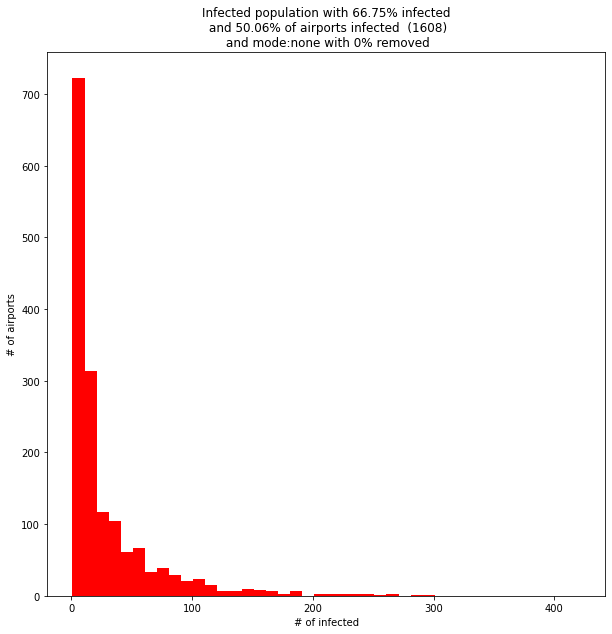

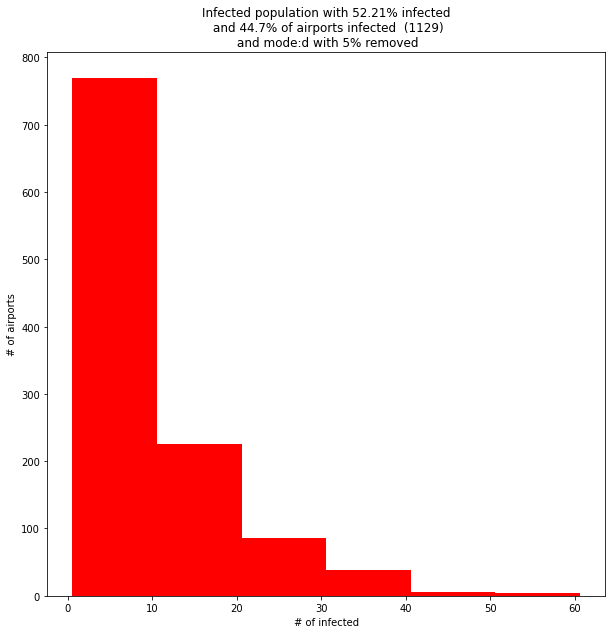

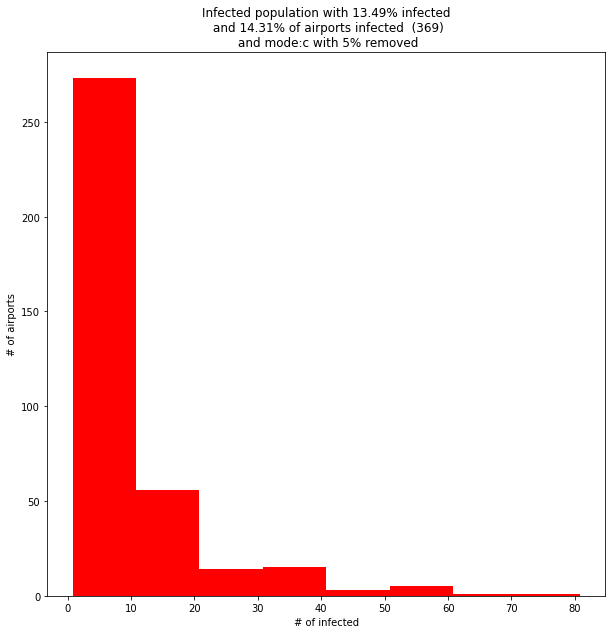

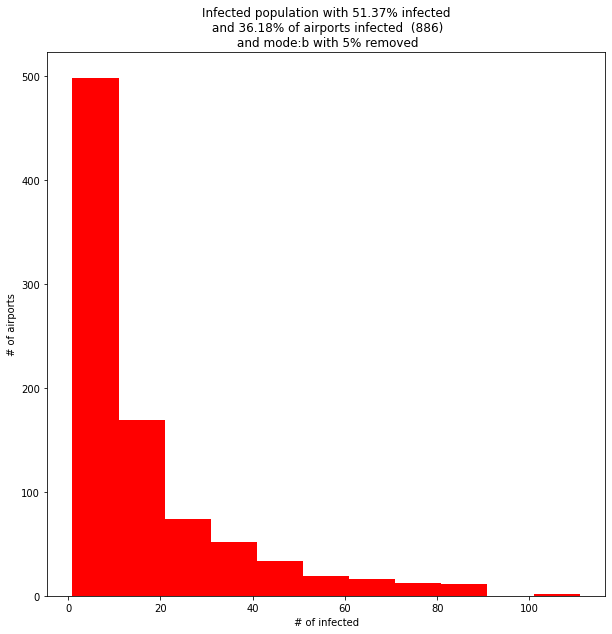

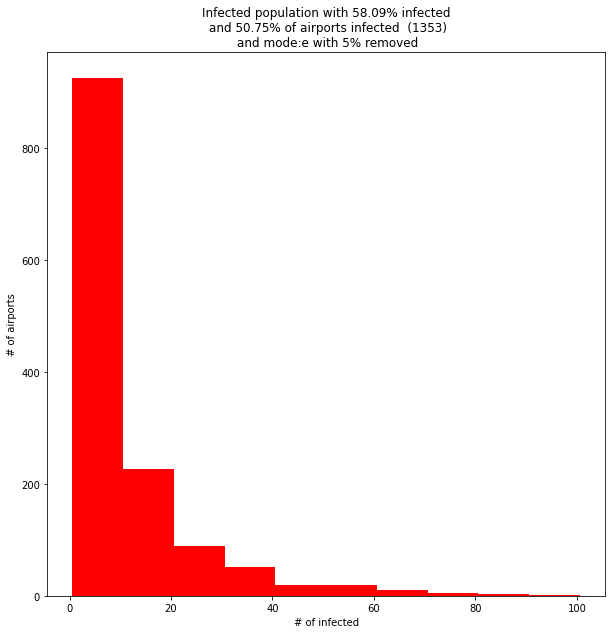

In [186]:
modes = ['d', 'c', 'b', 'e']
percentage = 5
histinfo(G, 0, 'none')
for i in modes:
  G_copy = remove_important_nodes(G,percentage, mode = i)
  SIR(G_copy, time, beta, gamma, rnd)
  histinfo(G_copy,percentage, mode = i)

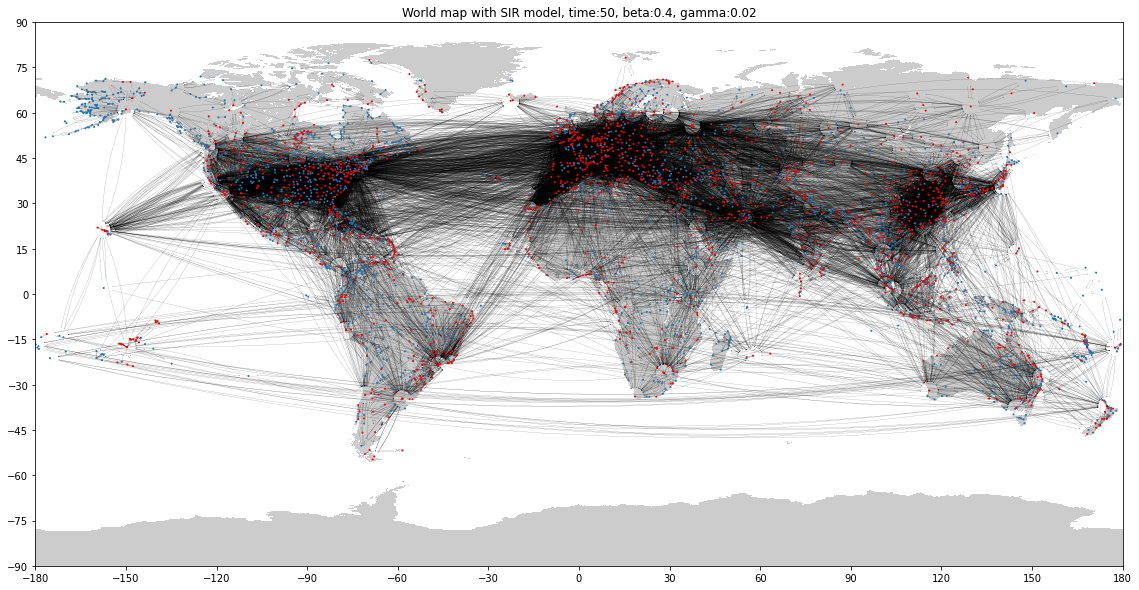

In [116]:
worldmap(G, time, beta, gamma)